In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD
import random
random.seed(0)
np.random.seed(0)

In [ ]:
!pip install recommenders

  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=3146e63fcd8b74b20b4c5a2f5876f81660a49441965756a0220ae4bbf12526c6
  Stored in directory: /root/.cache/pip/wheels/67/2b/fb/326e30d638c538e69a5eb0aa47f4223d979f502bbdb403950f
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=4cdea5576a418c3a8043c5931a7f5a159874f68b9fa6348a57b29af52320c8a7
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633991 sha256=2a42fe86b8fa5c40e1361dd55b4dbb608153673e0aac2eb3db4736fb612fbf0c
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built lightfm memory-profiler retrying scikit-surprise
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
   

In [ ]:

from recommenders.models.rbm.rbm import RBM
from recommenders.datasets.python_splitters import numpy_stratified_split
from recommenders.datasets.sparse import AffinityMatrix
from recommenders.datasets import movielens
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.utils.timer import Timer
from recommenders.utils.plot import line_graph

## Analyse Dataset

### Book  Dataset
https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset


In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

!gdown https://drive.google.com/uc?id=1TE3vZZf0yq9J2sTbDFL7BFNCDQIG6Nd-

Downloading...
From: https://drive.google.com/uc?id=1TE3vZZf0yq9J2sTbDFL7BFNCDQIG6Nd-
To: /content/Books.zip
100% 25.0M/25.0M [00:00<00:00, 39.3MB/s]


In [ ]:
!unzip "Books.zip"  -d  "/content"

Archive:  Books.zip
  inflating: /content/Books.csv      
  inflating: /content/Ratings.csv    
  inflating: /content/Users.csv      


In [ ]:
rating_df = pd.read_csv('Ratings.csv')
book_df = pd.read_csv('Books.csv')

In [ ]:
users_df = pd.read_csv('Users.csv')
users_df.head(5)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


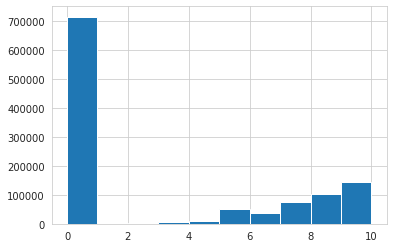

In [ ]:
rating_df=pd.merge(rating_df,book_df,on="ISBN",how="left")
rating_df['Book-Rating'].hist()

In [ ]:
y = rating_df.groupby('Book-Title').count()['Book-Rating']>=100
books = y[y].index
rating_df = rating_df[rating_df['Book-Title'].isin(books)]

In [ ]:
x = rating_df.groupby('User-ID').count()['Book-Rating'] > 100
userIndex = x[x].index
rating_df=rating_df[rating_df['User-ID'].isin(userIndex)]


In [ ]:
rating_df=rating_df[['User-ID','Book-Title','Book-Rating']]

In [ ]:
rating_df.rename(columns = {'User-ID':'userID','Book-Title':'itemID','Book-Rating':'rating'}, inplace = True)


In [ ]:
item_ids = list(set(list(rating_df.itemID.unique())))
user_ids = list(set(list(rating_df.userID.unique())))

In [ ]:
dict_users = {}
index = 0
for ids in sorted(user_ids):
    dict_users[ids] = index
    index += 1
dict_items = {}
index = 0
for ids in sorted(item_ids):
    dict_items[ids] = index
    index += 1

In [ ]:
rating_df['userID'] = rating_df.userID.map(dict_users)
rating_df['itemID'] = rating_df.itemID.map(dict_items)

In [ ]:
rating_df['userID'].unique()

array([209, 210,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
        11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
        24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,
        37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
        50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 17

### user/item affiity matrix 

In [ ]:
header = {
        "col_user": "userID",
        "col_item": "itemID",
        "col_rating": "rating",
    }

#instantiate the sparse matrix generation  
am = AffinityMatrix(df =rating_df, **header)

#obtain the sparse matrix 
X, _, _ = am.gen_affinity_matrix()

In [ ]:
Xtr, Xtst = numpy_stratified_split(X)


In [ ]:
#First we initialize the model class
model = RBM(
    possible_ratings=np.setdiff1d(np.unique(Xtr), np.array([0])),
    visible_units=X.shape[1],
    hidden_units=600,
    training_epoch=400,
    minibatch_size=10,
     display_epoch=10,
    keep_prob=0.1,
    with_metrics=True
)

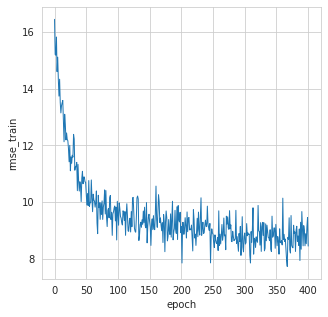

In [ ]:
# Model Fit
model.fit(Xtr)

# Plot the train RMSE as a function of the epochs
line_graph(values=model.rmse_train, labels='train', x_name='epoch', y_name='rmse_train')

In [ ]:
top_k_df = am.map_back_sparse(top_k, kind = 'prediction')
test_df = am.map_back_sparse(Xtst, kind = 'ratings')

In [ ]:
usersinTestDataset=list(test_df['User-ID'].unique())

HIT Rate

In [ ]:
total=0
hit=0
for i in usersinTestDataset:
    results= list(top_k_df[top_k_df['User-ID']==i]['Book-Title'] )   
  
    total+=1
    for rs in results:
        
        if(((test_df['Book-Title'] == rs) & (test_df['User-ID'] ==i)).any()):
                hit+=1
                break
        
hit_ratio=hit/total   
print(hit_ratio)

0.46919431279620855


MAP@K

In [ ]:
top_k_df = am.map_back_sparse(top_k, kind = 'prediction')

In [ ]:
total=0
hit=0
for i in usersinTestDataset:
    results= list(top_k_df[top_k_df['User-ID']==i]['Book-Title'] )   
  
    
    for rs in results:
        total+=1
        if(((test_df['Book-Title'] == rs) & (test_df['User-ID'] ==i)).any()):
                hit+=1
                
        
hit_ratio=hit/total   
print(hit_ratio)

0.03056872037914692
